<a href="https://colab.research.google.com/github/armandoordonez/eda_couse/blob/main/PCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Based on: Análisis de componentes princiaples PCA con Python by Joaquín Amat Rodrigo, available under a Attribution 4.0 International (CC BY 4.0) at https://www.cienciadedatos.net/documentos/py19-pca-python.html

El departamento de calidad de una empresa de alimentación se encarga de medir el contenido en grasa de la carne que comercializa. Este estudio se realiza mediante técnicas de analítica química, un proceso relativamente costoso en tiempo y recursos. Una alternativa que permitiría reducir costes y optimizar tiempo es emplear un espectrofotómetro (instrumento capaz de detectar la absorbancia que tiene un material a diferentes tipos de luz en función de sus características) e inferir el contenido en grasa a partir de sus medidas.

Antes de dar por válida esta nueva técnica, la empresa necesita comprobar qué margen de error tiene respecto al análisis químico. Para ello, se mide el espectro de absorbancia a 100 longitudes de onda en 215 muestras de carne, cuyo contenido en grasa se obtiene también por análisis químico, y se entrena un modelo con el objetivo de predecir el contenido en grasa a partir de los valores dados por el espectrofotómetro.

Los datos meatspec.csv empleados en este ejemplo se han obtenido del magnífico libro Linear Models with R, Second Edition.

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import statsmodels.api as sm

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import multiprocessing
# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
datos = pd.read_csv('https://raw.githubusercontent.com/armandoordonez/eda_couse/main/data/meatspec.csv')
datos = datos.drop(columns = datos.columns[0])
  

In [3]:
datos.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.30025,3.27907,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5


In [4]:
datos.shape

(215, 101)

In [5]:
# verificar correlacion entre variables

# Correlación entre columnas numéricas
# ==============================================================================

def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matriz de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)

corr_matrix = datos.select_dtypes(include=['float64', 'int']) \
              .corr(method='pearson')
display(tidy_corr_matrix(corr_matrix).head(5))

,variable_1,variable_2,r,abs_r
1019,V11,V10,0.999996,0.999996
919,V10,V11,0.999996,0.999996
1021,V11,V12,0.999996,0.999996
1121,V12,V11,0.999996,0.999996
917,V10,V9,0.999996,0.999996


In [6]:
# División de los datos en train y test
# ==============================================================================
X = datos.drop(columns='fat')
y = datos['fat']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [7]:
# Creación y entrenamiento del modelo
# ==============================================================================
modelo = LinearRegression(normalize=True)
modelo.fit(X = X_train, y = y_train)

LinearRegression(normalize=True)

In [8]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
# ==============================================================================
rmse_ols = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_ols}")


El error (rmse) de test es: 3.839667585595677


In [9]:
# Entrenamiento modelo de regresión precedido por PCA con escalado
# ==============================================================================
pipe_modelado = make_pipeline(StandardScaler(), PCA(), LinearRegression())
pipe_modelado.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])

In [10]:
pipe_modelado.set_params


<bound method Pipeline.set_params of Pipeline(steps=[('standardscaler', StandardScaler()), ('pca', PCA()),
                ('linearregression', LinearRegression())])>

In [11]:
# Predicciones test
# ==============================================================================
predicciones = pipe_modelado.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
# ==============================================================================
rmse_pcr = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_pcr}")


El error (rmse) de test es: 3.8396675856366214


In [14]:
# Grid de hiperparámetros evaluados
# ==============================================================================
param_grid = {'pca__n_components': [1, 2, 4, 6, 8, 10, 15, 20, 30, 50]}

# Búsqueda por grid search con validación cruzada
# ==============================================================================
grid = GridSearchCV(
        estimator  = pipe_modelado,
        param_grid = param_grid,
        scoring    = 'neg_root_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = KFold(n_splits=5, random_state=123,shuffle=True), 
        refit      = True,
        verbose    = 0,
        return_train_score = True,
        
       )

grid.fit(X = X_train, y = y_train)

# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(3)

,param_pca__n_components,mean_test_score,std_test_score,mean_train_score,std_train_score
8,30,-2.562054,1.072744,-1.499404,0.105063
5,10,-2.825356,0.514680,-2.442293,0.134784
9,50,-2.885758,1.029969,-0.985038,0.066330


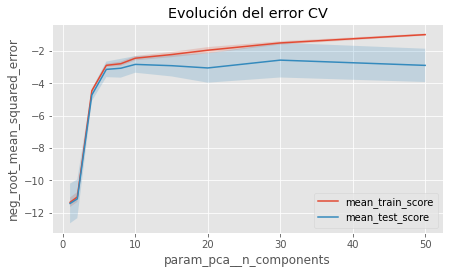

In [15]:
# Gráfico resultados validación cruzada para cada hiperparámetro
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 3.84), sharey=True)

resultados.plot('param_pca__n_components', 'mean_train_score', ax=ax)
resultados.plot('param_pca__n_components', 'mean_test_score', ax=ax)
ax.fill_between(resultados.param_pca__n_components.astype(np.float),
                resultados['mean_train_score'] + resultados['std_train_score'],
                resultados['mean_train_score'] - resultados['std_train_score'],
                alpha=0.2)
ax.fill_between(resultados.param_pca__n_components.astype(np.float),
                resultados['mean_test_score'] + resultados['std_test_score'],
                resultados['mean_test_score'] - resultados['std_test_score'],
                alpha=0.2)
ax.legend()
ax.set_title('Evolución del error CV')
ax.set_ylabel('neg_root_mean_squared_error');

In [16]:
# Mejores hiperparámetros por validación cruzada
# ==============================================================================
print("----------------------------------------")
print("Mejores hiperparámetros encontrados (cv)")
print("----------------------------------------")
print(grid.best_params_, ":", grid.best_score_, grid.scoring)

----------------------------------------
Mejores hiperparámetros encontrados (cv)
----------------------------------------
{'pca__n_components': 30} : -2.5620540741068263 neg_root_mean_squared_error


In [17]:
# Entrenamiento modelo de regresión precedido por PCA con escalado
# ==============================================================================
pipe_modelado = make_pipeline(StandardScaler(), PCA(n_components=5), LinearRegression())
pipe_modelado.fit(X=X_train, y=y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('pca', PCA(n_components=5)),
                ('linearregression', LinearRegression())])

In [18]:
# Predicciones test
# ==============================================================================
predicciones = pipe_modelado.predict(X=X_test)
predicciones = predicciones.flatten()

# Error de test del modelo 
# ==============================================================================
rmse_pcr = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
            squared = False
           )
print("")
print(f"El error (rmse) de test es: {rmse_pcr}")


El error (rmse) de test es: 3.359334804522669
